# Story 4

Andrew Bowen    
DATA 608    
CUNY Data Science

**Question**: *How much do we get paid?*

In [20]:
import pandas as pd
import requests
import os
import plotly.express as px
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

## Introduction and Data Sources

I was able to find data from the Bureau of Labor Statistics website including salary. The BLS API is a good starting point for grabbing salary data per state by occupation, and this [excel dataset from May 2022 was available](https://www.bls.gov/oes/current/oessrcst.htm).

In [3]:
df = pd.read_excel("./data/bls-state-wage-data-May2022.xlsx")
df.head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,18.5,28.94,43.25,21580,28030,38470,60190,89950,NaN,NaN
1,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,46.12,63.53,86.89,47680,66210,95940,132150,180730,NaN,NaN
2,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,65.83,90.64,#,50920,108470,136930,188530,#,NaN,NaN
3,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,47.17,71.64,105.19,44530,65280,98120,149010,218800,NaN,NaN
4,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1031,Legislators,...,*,*,*,17080,18130,20320,35730,57060,True,NaN


State data is pulled from plotly's publically-available GeoJSON for geographic data

In [4]:
geojson_path = "./data/us-states.json"
with open(geojson_path, "r") as f:
    states = json.load(f)

## Data Wrangling

We'll need to clean our source data a bit to make it more readable and usable for later visualization

In [5]:
def clean_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform basic cleaning of a pandas dataframe
    Convert columns to `snake_case`
    """        
    new_cols = [c.lower() for c in df.columns]
    df.columns = new_cols
    
    return df
    

In [6]:
df = clean_table(df)
df.head()

,area,area_title,area_type,prim_state,naics,naics_title,i_group,own_code,occ_code,occ_title,...,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,annual,hourly
0,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,18.5,28.94,43.25,21580,28030,38470,60190,89950,NaN,NaN
1,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,46.12,63.53,86.89,47680,66210,95940,132150,180730,NaN,NaN
2,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,65.83,90.64,#,50920,108470,136930,188530,#,NaN,NaN
3,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,47.17,71.64,105.19,44530,65280,98120,149010,218800,NaN,NaN
4,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1031,Legislators,...,*,*,*,17080,18130,20320,35730,57060,True,NaN


Enforcing some types for plotting libraries later

In [7]:
# Fill Bad Values
df = df.replace("**", 0)
df = df.replace("*", 0)
df = df.replace("#", 0)

df.head()

,area,area_title,area_type,prim_state,naics,naics_title,i_group,own_code,occ_code,occ_title,...,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,annual,hourly
0,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,18.50,28.94,43.25,21580,28030,38470,60190,89950,NaN,NaN
1,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,46.12,63.53,86.89,47680,66210,95940,132150,180730,NaN,NaN
2,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1011,Chief Executives,...,65.83,90.64,0.00,50920,108470,136930,188530,0,NaN,NaN
3,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,47.17,71.64,105.19,44530,65280,98120,149010,218800,NaN,NaN
4,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,11-1031,Legislators,...,0.00,0.00,0.00,17080,18130,20320,35730,57060,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37564,78,Virgin Islands,3,VI,0,Cross-industry,cross-industry,1235,53-7051,Industrial Truck and Tractor Operators,...,15.15,17.63,18.24,25860,29010,31520,36680,37940,NaN,NaN
37565,78,Virgin Islands,3,VI,0,Cross-industry,cross-industry,1235,53-7061,Cleaners of Vehicles and Equipment,...,13.92,14.86,16.63,23360,28510,28950,30910,34590,NaN,NaN
37566,78,Virgin Islands,3,VI,0,Cross-industry,cross-industry,1235,53-7062,"Laborers and Freight, Stock, and Material Move...",...,13.73,15.66,19.19,24520,26640,28550,32570,39920,NaN,NaN
37567,78,Virgin Islands,3,VI,0,Cross-industry,cross-industry,1235,53-7064,"Packers and Packagers, Hand",...,12.59,13.79,17.31,22710,22940,26180,28690,36000,NaN,NaN


In [8]:
# Convert float type columns (percentages and hourly wages)
float_cols = ['pct_total', 'pct_rpt',
       'h_mean', 'a_mean', 'mean_prse', 'h_pct10', 'h_pct25', 'h_median',
       'h_pct75', 'h_pct90']

for fc in float_cols:
    df[fc] = df[fc].astype(float)

# Convert int columns for annual wages
int_cols = ['a_pct10', 'a_pct25', 'a_median', 'a_pct75',
            'a_pct90']
for ic in int_cols:
    df[ic] = df[ic].fillna(0)
    df[ic] = df[ic].astype(int)


## Data Visualization

In [10]:
data_jobs = df.loc[df.occ_title.str.contains("Data")]
data_jobs.head()

,area,area_title,area_type,prim_state,naics,naics_title,i_group,own_code,occ_code,occ_title,...,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,annual,hourly
73,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,15-1242,Database Administrators,...,39.33,50.78,62.10,52340,66440,81810,105630,129160,NaN,NaN
74,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,15-1243,Database Architects,...,57.41,67.18,93.09,68770,82480,119410,139730,193630,NaN,NaN
85,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,15-2051,Data Scientists,...,41.29,53.00,66.56,52260,66080,85870,110240,138450,NaN,NaN
485,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,43-9021,Data Entry Keyers,...,14.35,16.81,18.72,22990,26770,29850,34960,38930,NaN,NaN
804,2,Alaska,2,AK,0,Cross-industry,cross-industry,1235,15-1242,Database Administrators,...,40.06,52.57,60.24,58970,69450,83330,109340,125300,NaN,NaN


In [11]:
# Getting Data Science-specific jobs first
data_science = df.loc[df.occ_title == "Data Scientists"]
data_science.head()

,area,area_title,area_type,prim_state,naics,naics_title,i_group,own_code,occ_code,occ_title,...,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,annual,hourly
85,1,Alabama,2,AL,0,Cross-industry,cross-industry,1235,15-2051,Data Scientists,...,41.29,53.00,66.56,52260,66080,85870,110240,138450,NaN,NaN
815,2,Alaska,2,AK,0,Cross-industry,cross-industry,1235,15-2051,Data Scientists,...,48.09,62.91,77.07,62130,74740,100040,130860,160310,NaN,NaN
1390,4,Arizona,2,AZ,0,Cross-industry,cross-industry,1235,15-2051,Data Scientists,...,49.41,60.90,75.67,61970,78220,102770,126670,157390,NaN,NaN
2845,6,California,2,CA,0,Cross-industry,cross-industry,1235,15-2051,Data Scientists,...,60.97,82.16,110.95,63920,85010,126810,170890,230780,NaN,NaN
3671,8,Colorado,2,CO,0,Cross-industry,cross-industry,1235,15-2051,Data Scientists,...,49.62,64.90,79.78,62140,79370,103200,134990,165930,NaN,NaN


In [ ]:
# Plotting mean salaries by data-related job title
data_jobs_mean_salaries = data_jobs.groupby("occ_title")['occ_title', 'h_mean'].mean()
data_jobs_mean_salaries['occ_title'] = data_jobs_mean_salaries.index
px.bar(data_jobs_mean_salaries, x="occ_title", y="h_mean", labels={"occ_title": "Job Title", "h_mean": "Hourly Mean Salary ($)"},
       title="Hourly mean salaries for data-related jobs - All US May 2022<br><sup>Data Scientists earn well over the national average hourly wage.</sup></br>"
)

In [12]:
# Plot a choropleth using plotly: Hourly median DS salaries
fig = px.choropleth(data_science, geojson=states, locations='area_title', color='h_median',
                    color_continuous_scale="Viridis",
                    scope="usa", featureidkey='properties.name',
                    labels={'h_median': 'Median hourly wage'},
                    title="""Data Scientist Median Salary by State ($)<br><sup>Larger economy states (CA, NY, etc.) tend to have higher median salaries for data scientists, with some outliers (Wyoming)</sup>""")

fig.show()

We can also plot annual median salaries, which we'd expect to look similar to our heatmap of hourly median wages above.

In [19]:
# Plot annual median salaries for DS
fig = px.choropleth(data_science, geojson=states, locations='area_title', color='a_median',
                    color_continuous_scale="Viridis",
                    scope="usa", featureidkey='properties.name',
                    labels={'a_median': 'Data Science Median Annual Wage'},
                    title="""Data Scientist Annual Median Salary by State ($)<br><sup>The same story as hourly median salaries. Larger economy states (CA, NY, etc.) tend to have higher annual median salaries for data scientists</sup>""")

fig.show()

We can also plot a categorical heatmap between states and data-related jobs. We can use [Seaborn here to plot a categorical 2-D histogram across states and data-related job title](https://stackoverflow.com/questions/63597612/how-to-draw-a-2d-chart-with-categorical-variables-plus-marginals)

In [23]:
# First, group our data by state and data title
data_salary_by_state = data_jobs.groupby(['area_title', 'occ_title'])['a_mean'].mean()

# Convert our grouped series to a dataframe for plotting
dat = data_salary_by_state.to_frame().reset_index()
dat.head()

area_title  occ_title              
Alabama     Data Entry Keyers           31000.0
            Data Scientists             91570.0
            Database Administrators     87090.0
            Database Architects        119590.0
Alaska      Data Entry Keyers           42280.0
                                         ...   
Wisconsin   Database Administrators     93590.0
            Database Architects        121770.0
Wyoming     Data Entry Keyers           34790.0
            Data Scientists            128860.0
            Database Administrators     73420.0
Name: a_mean, Length: 204, dtype: float64

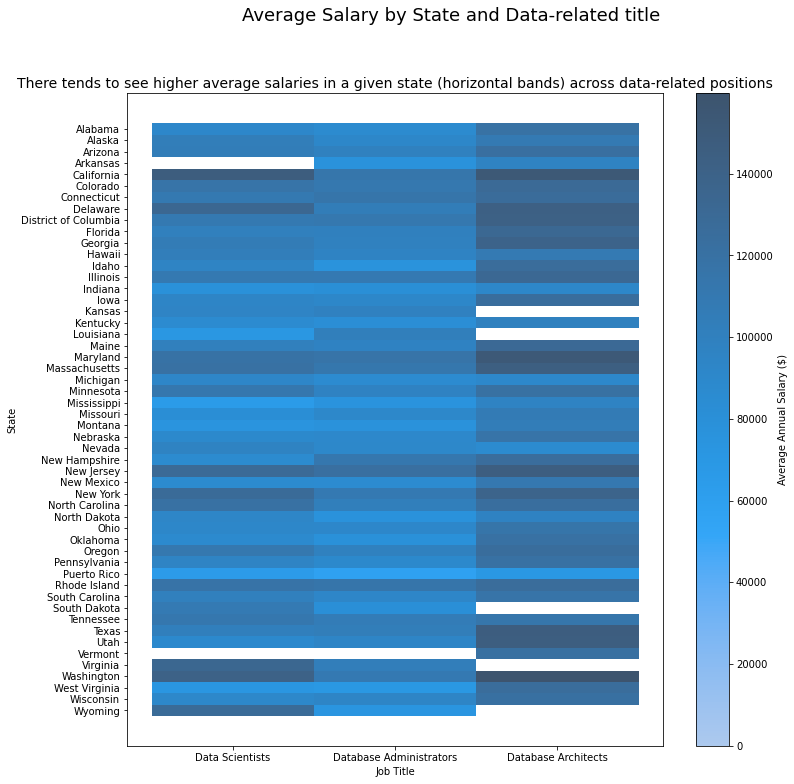

In [83]:
# sns.JointGrid(x='area_title', y='occ_title', data=dat)
f, ax = plt.subplots(figsize=(12, 12))

# Plot categorical 2-D Histogram
sns.histplot(data=dat.loc[dat.occ_title != "Data Entry Keyers"],
             x='occ_title', y='area_title',
             weights="a_mean", cbar=True,
             cbar_kws={'label': "Average Annual Salary ($)"})

ax.set_xlabel("Job Title")
ax.set_ylabel("State")
plt.suptitle("Average Salary by State and Data-related title", fontsize=18)
plt.title("There tends to see higher average salaries in a given state (horizontal bands) across data-related positions",  fontsize=14)


plt.show()